In [ ]:
%env SHELL=/bin/bash

In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
from adjustText import adjust_text

In [2]:
indir = '/public/home/msu/projects/seq3/20230530/8_regulons'
os.chdir( indir )

### Driver regulons

In [79]:
MOTIFS_FNAME = f"{indir}/genes_fine/regulons.csv"
df_motifs = load_motifs(MOTIFS_FNAME)
df_motifs.head()
#df_motifs.to_csv("regulon_motifs.tsv", sep = "\t")
# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"

Enrichment                                  \
                                AUC       NES MotifSimilarityQvalue   
TF     MotifID                                                        
BCLAF1 metacluster_138.2   0.057585  3.170610          3.126730e-09   
BRCA1  metacluster_33.8    0.046504  3.624946          0.000000e+00   
CEBPA  tfdimers__MD00404   0.048556  3.238378          8.753350e-07   
       tfdimers__MD00064   0.048063  3.175499          7.443490e-07   
       tfdimers__MD00357   0.049147  3.313734          1.571660e-08   

                                              \
                         OrthologousIdentity   
TF     MotifID                                 
BCLAF1 metacluster_138.2                 1.0   
BRCA1  metacluster_33.8                  1.0   
CEBPA  tfdimers__MD00404                 1.0   
       tfdimers__MD00064                 1.0   
       tfdimers__MD00357                 1.0   

                                                                             \
                                                                 Annotation   
TF     MotifID                                                                
BCLAF1 metacluster_138.2  motif similar to transfac_pro__M04704 ('V$BCLA...   
BRCA1  metacluster_33.8                          gene is directly annotated   
CEBPA  tfdimers__MD00404  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00064  gene is annotated for similar motif tfdimers__...   
       tfdimers__MD00357  gene is annotated for similar motif tfdimers__...   

                                                                             \
                                                                    Context   
TF     MotifID                                                                
BCLAF1 metacluster_138.2  (hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
BRCA1  metacluster_33.8   (hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
CEBPA  tfdimers__MD00404  (hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
       tfdimers__MD00064  (hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   
       tfdimers__MD00357  (hg38_10kbp_up_10kbp_down_full_tx_v10_clust.ge...   

                                                                             \
                                                                TargetGenes   
TF     MotifID                                                                
BCLAF1 metacluster_138.2  [(UBE3A, 1.4560540612980912), (RDX, 1.78114999...   
BRCA1  metacluster_33.8   [(SCMH1, 0.7556442563616306), (CUL1, 0.5044064...   
CEBPA  tfdimers__MD00404  [(TTYH3, 4.623245116448596), (HMOX1, 2.0560250...   
       tfdimers__MD00064  [(MAFB, 1.458176999740366), (CTSD, 4.394380838...   
       tfdimers__MD00357  [(SLFN12, 0.5066035473137532), (SIPA1, 0.42194...   

                                    
                         RankAtMax  
TF     MotifID                      
BCLAF1 metacluster_138.2      4942  
BRCA1  metacluster_33.8       4937  
CEBPA  tfdimers__MD00404       525  
       tfdimers__MD00064      1256  
       tfdimers__MD00357      4572

In [77]:
def derive_regulons(motifs):
    #motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs['Context']), dtype=bool) & \
        #np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs['Context']), dtype=bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

In [84]:
regulons = derive_regulons(df_motifs)
REGULONS_DAT_FNAME = "regulons.dat"
with open(REGULONS_DAT_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

KeyError: 'Context'

### Regulon activity binarization

#### genes

In [35]:
cellAnnot_genes = pd.read_table(f"{indir}/genes_fine/celltype.genes_fine.tsv", 
                                sep='\t', index_col=0, dtype = {'cell_type':'category'})
cellAnnot_trans = pd.read_table(f"{indir}/trans_fine/celltype.trans_fine.tsv", 
                                sep='\t', index_col=0, dtype = {'cell_type':'category'})
cats_genes = sorted(list(set(cellAnnot_genes['cell_type'])))
cats_trans = sorted(list(set(cellAnnot_trans['cell_type'])))

In [36]:
auc_mtx = pd.read_csv(f"{indir}/genes_fine/auc_mtx.normal.csv", 
                      index_col=0)
# need to transpose when using pipe cmd shell
#auc_mtx = pd.read_csv("~/projects/seq3/20230530/8_regulons/auc_mtx.csv", index_col=0)

In [5]:
auc_mtx.shape

(18769, 182)

In [37]:
#bin_mtx, thresholds = binarize(auc_mtx, num_workers=20) 
BIN_MTX_FNAME = f"{indir}/genes_fine/bin.csv"
THR_FNAME = f"{indir}/genes_fine/thresholds.csv"
#bin_mtx.to_csv(BIN_MTX_FNAME) 
#thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)
bin_mtx = pd.read_csv(BIN_MTX_FNAME, index_col=0)
thresholds = pd.read_csv(THR_FNAME, index_col=0).threshold

In [7]:
### CELL TYPE SPECIFIC REGULATORS - Z-SCORE

KeyError: 'MITF'

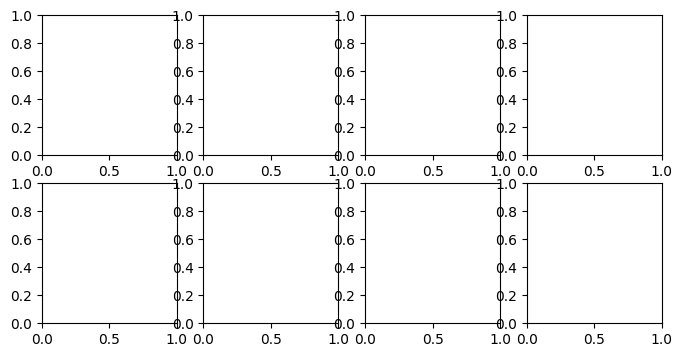

In [22]:
# futher plot for specific regulons
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 4), dpi=100)

plot_binarization(auc_mtx, 'NFKB2', thresholds['NFKB2'], ax=ax1)
plot_binarization(auc_mtx, 'MITF', thresholds['MITF'], ax=ax2)
plot_binarization(auc_mtx, 'FOXP3', thresholds['FOXP3'], ax=ax3)
plot_binarization(auc_mtx, 'PAX5', thresholds['PAX5'], ax=ax4)
plot_binarization(auc_mtx, 'IRF8', thresholds['IRF8'], ax=ax5)
plot_binarization(auc_mtx, 'IRF3', thresholds['IRF3'], ax=ax6)
plot_binarization(auc_mtx, 'MLX', thresholds['MLX'], ax=ax7)
plot_binarization(auc_mtx, 'YY1', thresholds['YY1'], ax=ax8)

plt.tight_layout()
savesvg('hists - GSE115978 - binarization.svg', fig)

In [38]:
def savesvg(fname: str, fig, folder: str=indir) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')
# heatmap
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, 
                horizontalalignment='center', verticalalignment='center')
    return f

/opt/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


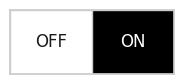

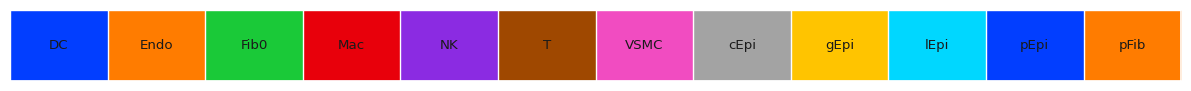

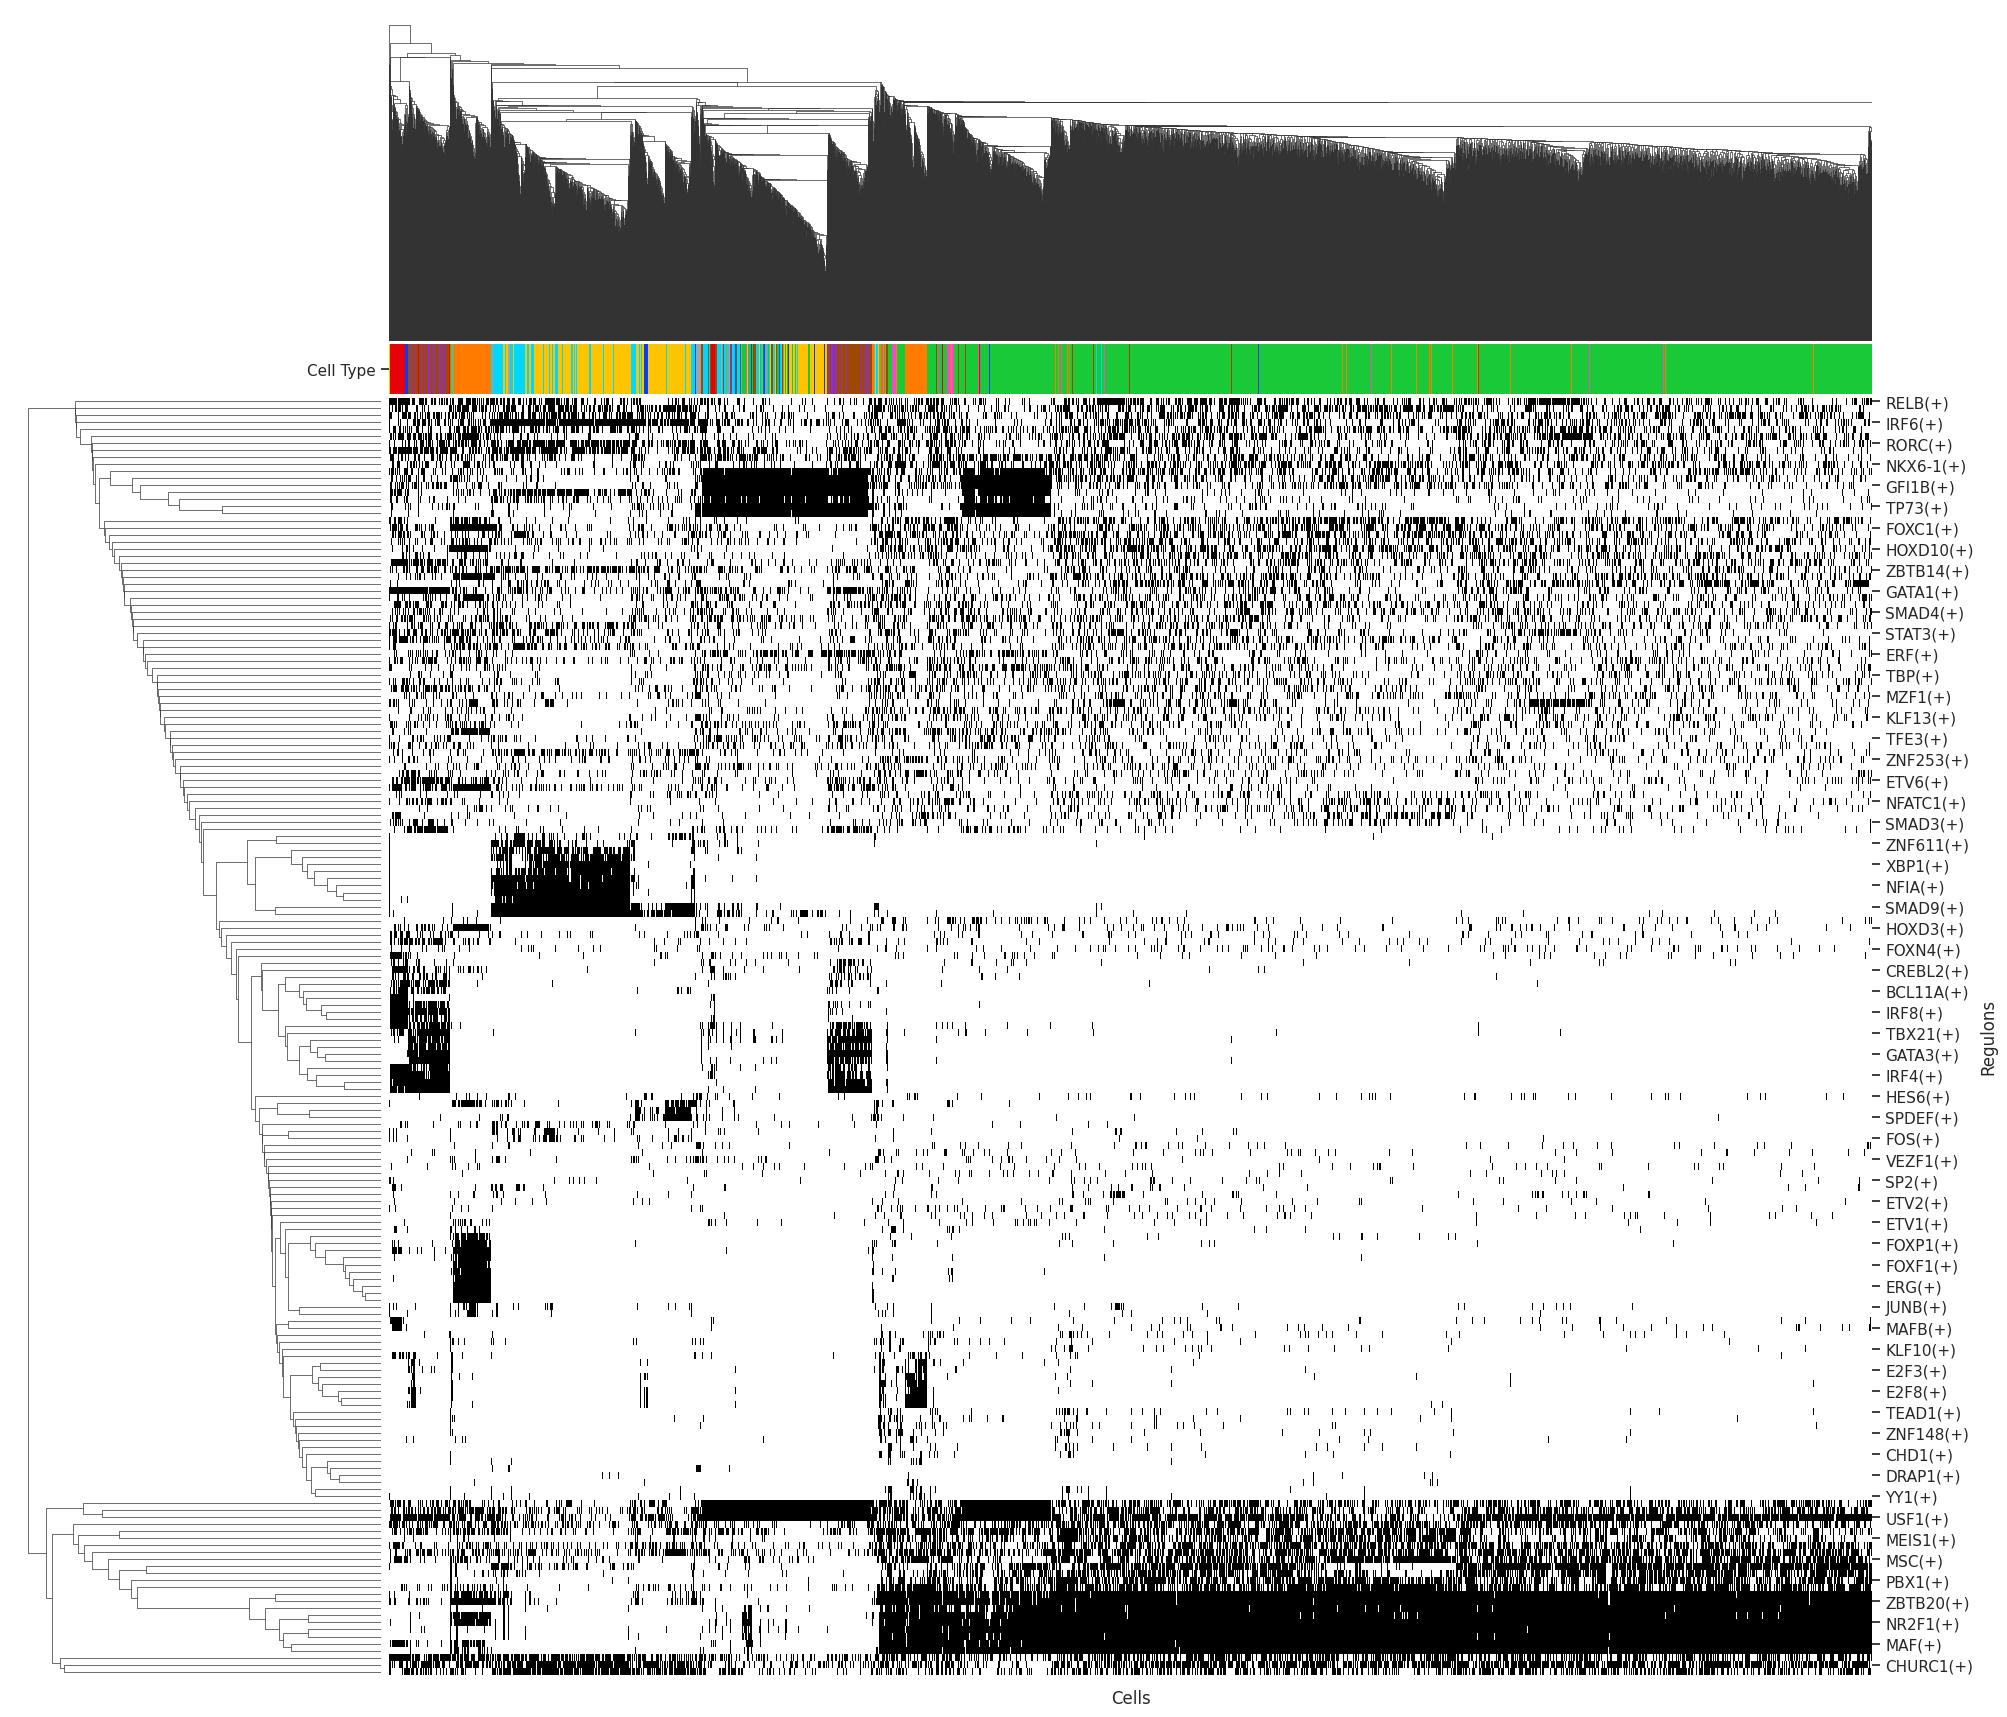

In [68]:
# plot binarize for genes
COLORS = sns.color_palette('bright',n_colors=len(cats_genes))
cell_type_color_lut = dict(zip(cats_genes,  COLORS))
cell_id2cell_type_lut = cellAnnot_genes.cell_type.to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('genes- on_off.svg', fig)

sns.set()
sns.set(font_scale=0.8)
fig = palplot(sns.color_palette(COLORS), cellAnnot_genes.cell_type.dtype.categories, size=1.0)
savesvg('genes-cell_type_colors.svg', fig)


sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(bin_mtx.T, 
               col_colors=auc_mtx.index.map(cell_id2cell_type_lut).map(cell_type_color_lut),
               cmap=bw_palette, figsize=(20,20))
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
g.fig.savefig(f"{indir}/genes-binarize-map.png", format='png')

In [78]:
len(cells)

11265

/opt/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


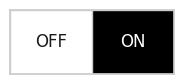

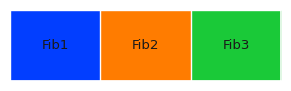

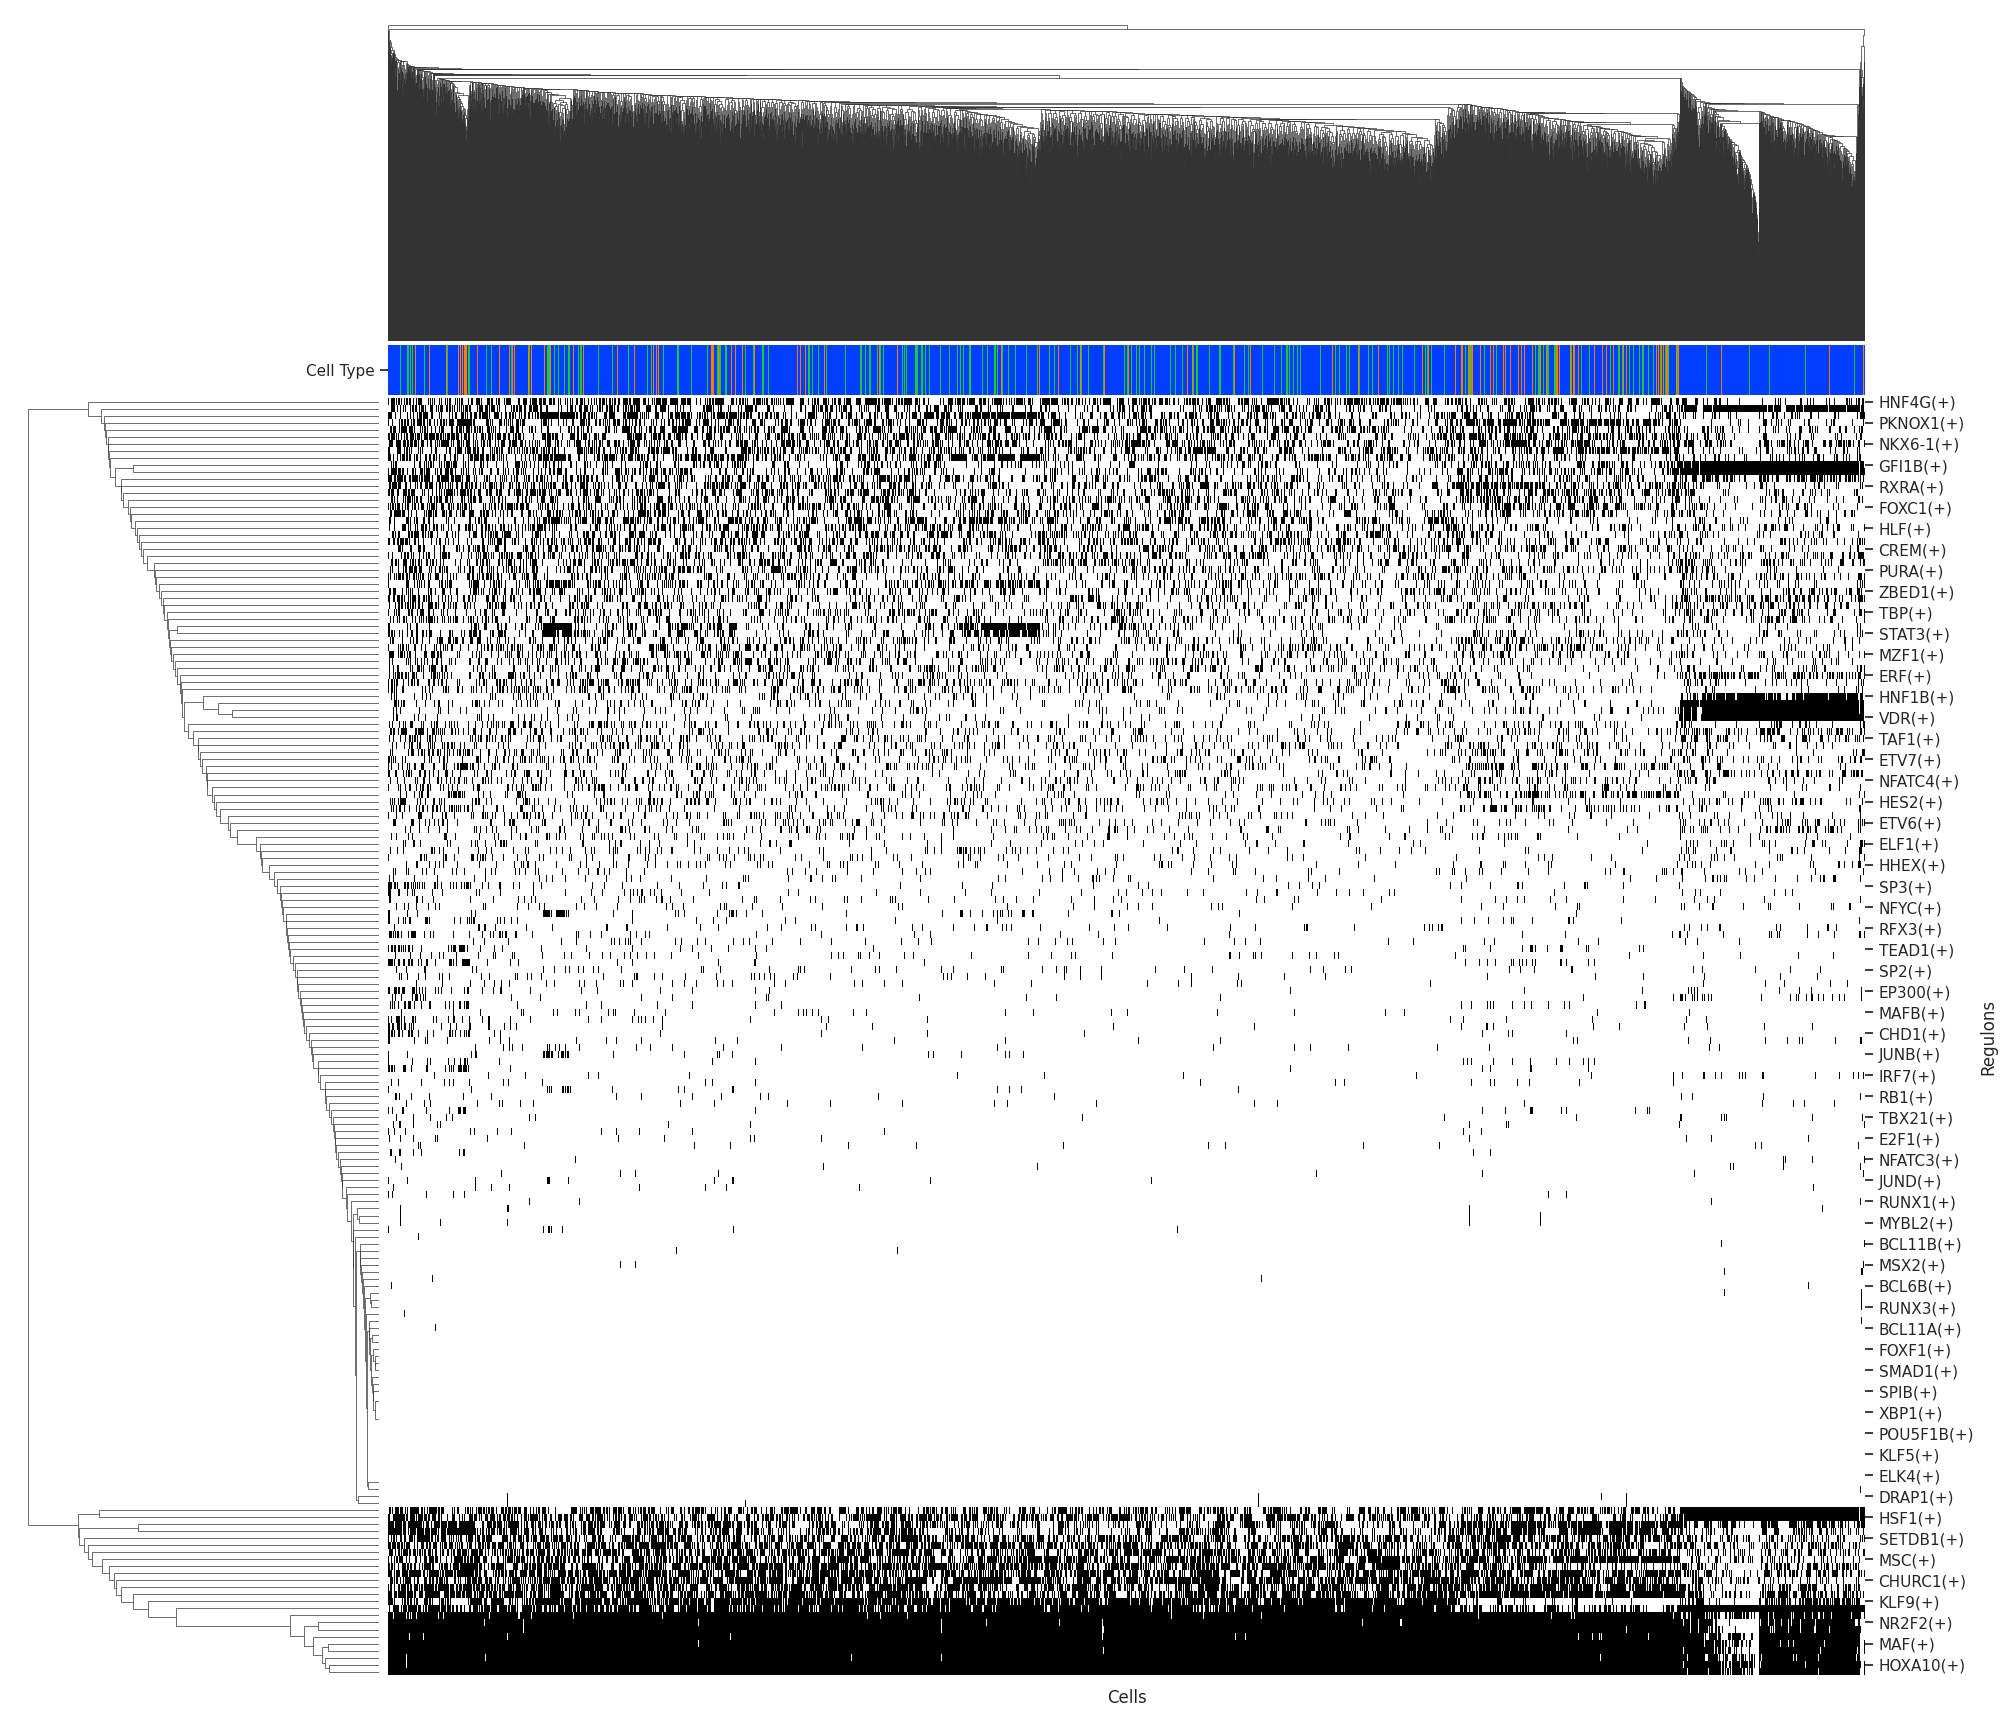

In [88]:
# plot binarize for trans
cells = cellAnnot_trans[cellAnnot_trans['cell_type'].str.contains("Fib") ].index.values
cats_trans = ['Fib1', 'Fib2', 'Fib3']
COLORS = sns.color_palette('bright',n_colors=len(cats_trans))
cell_type_color_lut = dict(zip(cats_trans,  COLORS))
cell_type_color_lut
cell_id2cell_type_lut = cellAnnot_trans.loc[cells, ].cell_type.to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('legend - on_off.svg', fig)

sns.set()
sns.set(font_scale=0.8)
fig = palplot(sns.color_palette(COLORS), cats_trans, size=1.0)
savesvg('trans-cell_type_colors.svg', fig)

sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(bin_mtx.loc[cells,].T, 
               col_colors=auc_mtx.loc[cells,].index.map(cell_id2cell_type_lut).map(cell_type_color_lut),
               cmap=bw_palette, figsize=(20,20))
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
g.fig.savefig(f"{indir}/trans-binarize-map.png", format='png')

### Regulon specificity scores (RSS) across predicted cell types

In [130]:
rss_cellType = regulon_specificity_scores(auc_mtx, cellAnnot["cell_type"])
rss_cellType.to_csv("cellType-regulon_specificity_scores.csv")
rss.head()

,ALX3(+),AR(+),ARID3A(+),ARID5B(+),ARNT(+),ARNT2(+),ATF3(+),ATF4(+),ATF6B(+),ATF7(+),...,ZNF69(+),ZNF707(+),ZNF76(+),ZNF770(+),ZNF772(+),ZNF775(+),ZNF814(+),ZNF841(+),ZSCAN25(+),ZXDC(+)
CD4 T cells,0.362445,0.212174,0.360819,0.381759,0.265083,0.213629,0.357586,0.343144,0.392251,0.334114,...,0.325572,0.211158,0.434452,0.294580,0.246919,0.171084,0.302906,0.415951,0.329061,0.283913
Monocytes,0.200889,0.288611,0.384007,0.258551,0.312877,0.172309,0.524326,0.320102,0.306754,0.332209,...,0.297315,0.202993,0.306269,0.578898,0.254314,0.176399,0.190689,0.276967,0.272406,0.345835
NK cells,0.255676,0.175134,0.240864,0.222249,0.228447,0.167924,0.229023,0.206866,0.217978,0.224963,...,0.201209,0.189873,0.222634,0.204194,0.216376,0.187944,0.251567,0.236663,0.216589,0.215014
B cells,0.267891,0.320413,0.298550,0.336900,0.337474,0.372010,0.272654,0.313725,0.285435,0.315307,...,0.295634,0.363237,0.329989,0.262377,0.262621,0.176273,0.261672,0.298898,0.281179,0.248580
Unknown,0.288514,0.195785,0.262331,0.260274,0.266424,0.206482,0.254414,0.284975,0.274162,0.234929,...,0.251545,0.192880,0.280727,0.234454,0.227579,0.167445,0.248163,0.254210,0.244660,0.238179


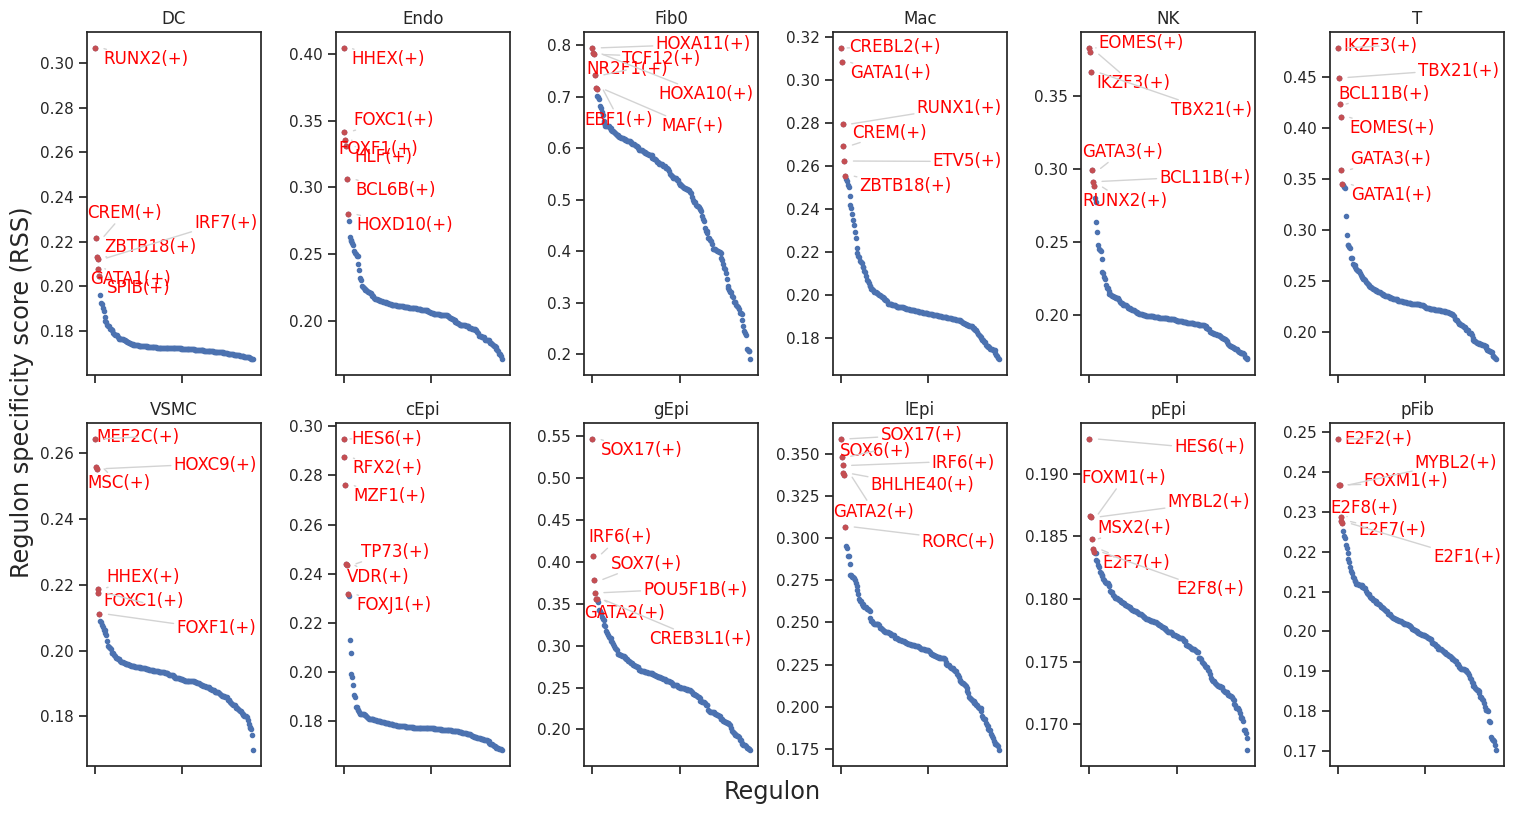

In [92]:
# rss_genes = pd.read_csv(f"{indir}/genes_fine/cellType-regulon_specificity_scores.csv",index_col=0)
rss_genes = regulon_specificity_scores(auc_mtx, cellAnnot_genes["cell_type"])
cats_genes = sorted(list(set(cellAnnot_genes['cell_type'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats_genes, range(1,len(cats_genes)+1)):
    x=rss_genes.T[c]
    ax = fig.add_subplot(2,6,num)
    plot_rss(rss_genes, c, top_n=6, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("genes-cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()


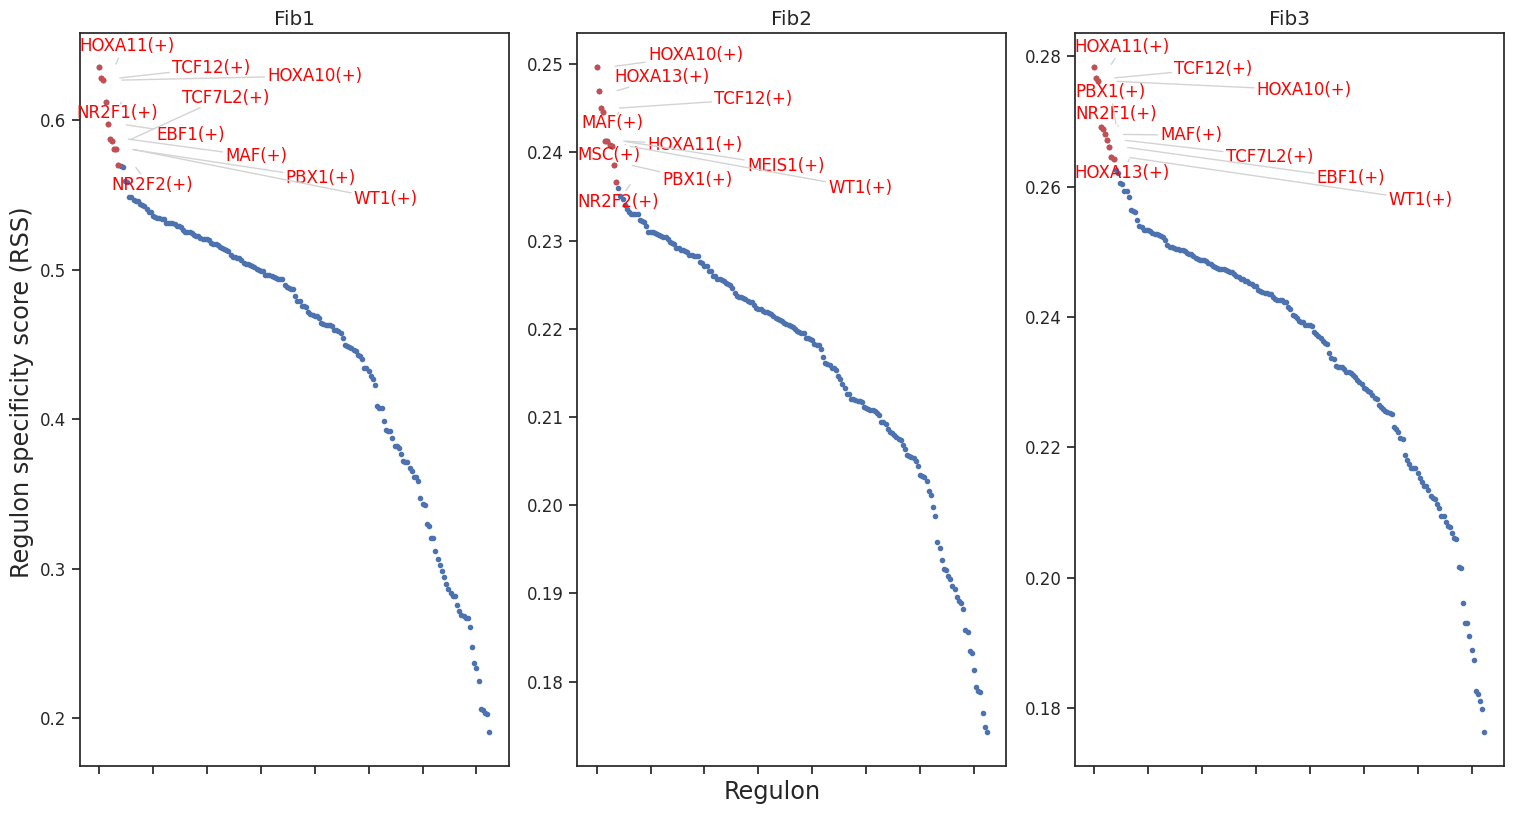

In [96]:
#rss_trans = pd.read_csv(f"{indir}/trans_fine/cellType-regulon_specificity_scores.csv",index_col=0)
#rss_trans = regulon_specificity_scores(auc_mtx, cellAnnot_trans["cell_type"])
#cats_trans = sorted(list(set(cellAnnot_trans['cell_type'])))
cats_trans = ['Fib1', 'Fib2', 'Fib3']
fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats_trans, range(1,len(cats_trans)+1)):
    x=rss_trans.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_trans, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("trans-cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

#### Select the top 5 regulons from each cell type

In [97]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

/tmp/msu/ipykernel_69157/850879095.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/msu/ipykernel_69157/850879095.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/msu/ipykernel_69157/850879095.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [103]:
rss_trans.loc[cats_trans,]

,ARID3A(+),ATF3(+),BCL11A(+),BCL11B(+),BCL6B(+),BCLAF1(+),BHLHE40(+),BRCA1(+),CDC5L(+),CEBPA(+),...,ZBTB14(+),ZBTB18(+),ZBTB20(+),ZBTB40(+),ZGPAT(+),ZNF148(+),ZNF202(+),ZNF253(+),ZNF354C(+),ZNF611(+)
Fib1,0.515404,0.475722,0.503738,0.377044,0.493959,0.530516,0.275984,0.533707,0.516269,0.494820,...,0.268630,0.237327,0.568947,0.407865,0.462931,0.548703,0.522600,0.284060,0.409212,0.488339
Fib2,0.227533,0.210692,0.225950,0.195101,0.222409,0.230836,0.185662,0.230965,0.228304,0.219794,...,0.190885,0.179426,0.233532,0.208606,0.215557,0.234702,0.222261,0.205455,0.216027,0.217714
Fib3,0.247410,0.238772,0.247700,0.206890,0.242581,0.252631,0.201728,0.252238,0.246657,0.242824,...,0.208588,0.191137,0.260485,0.225381,0.236809,0.256052,0.245795,0.210712,0.227480,0.238672


/opt/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


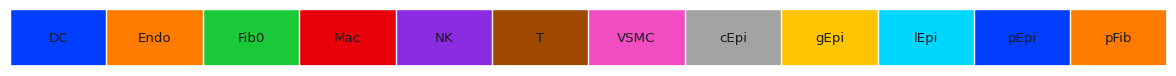

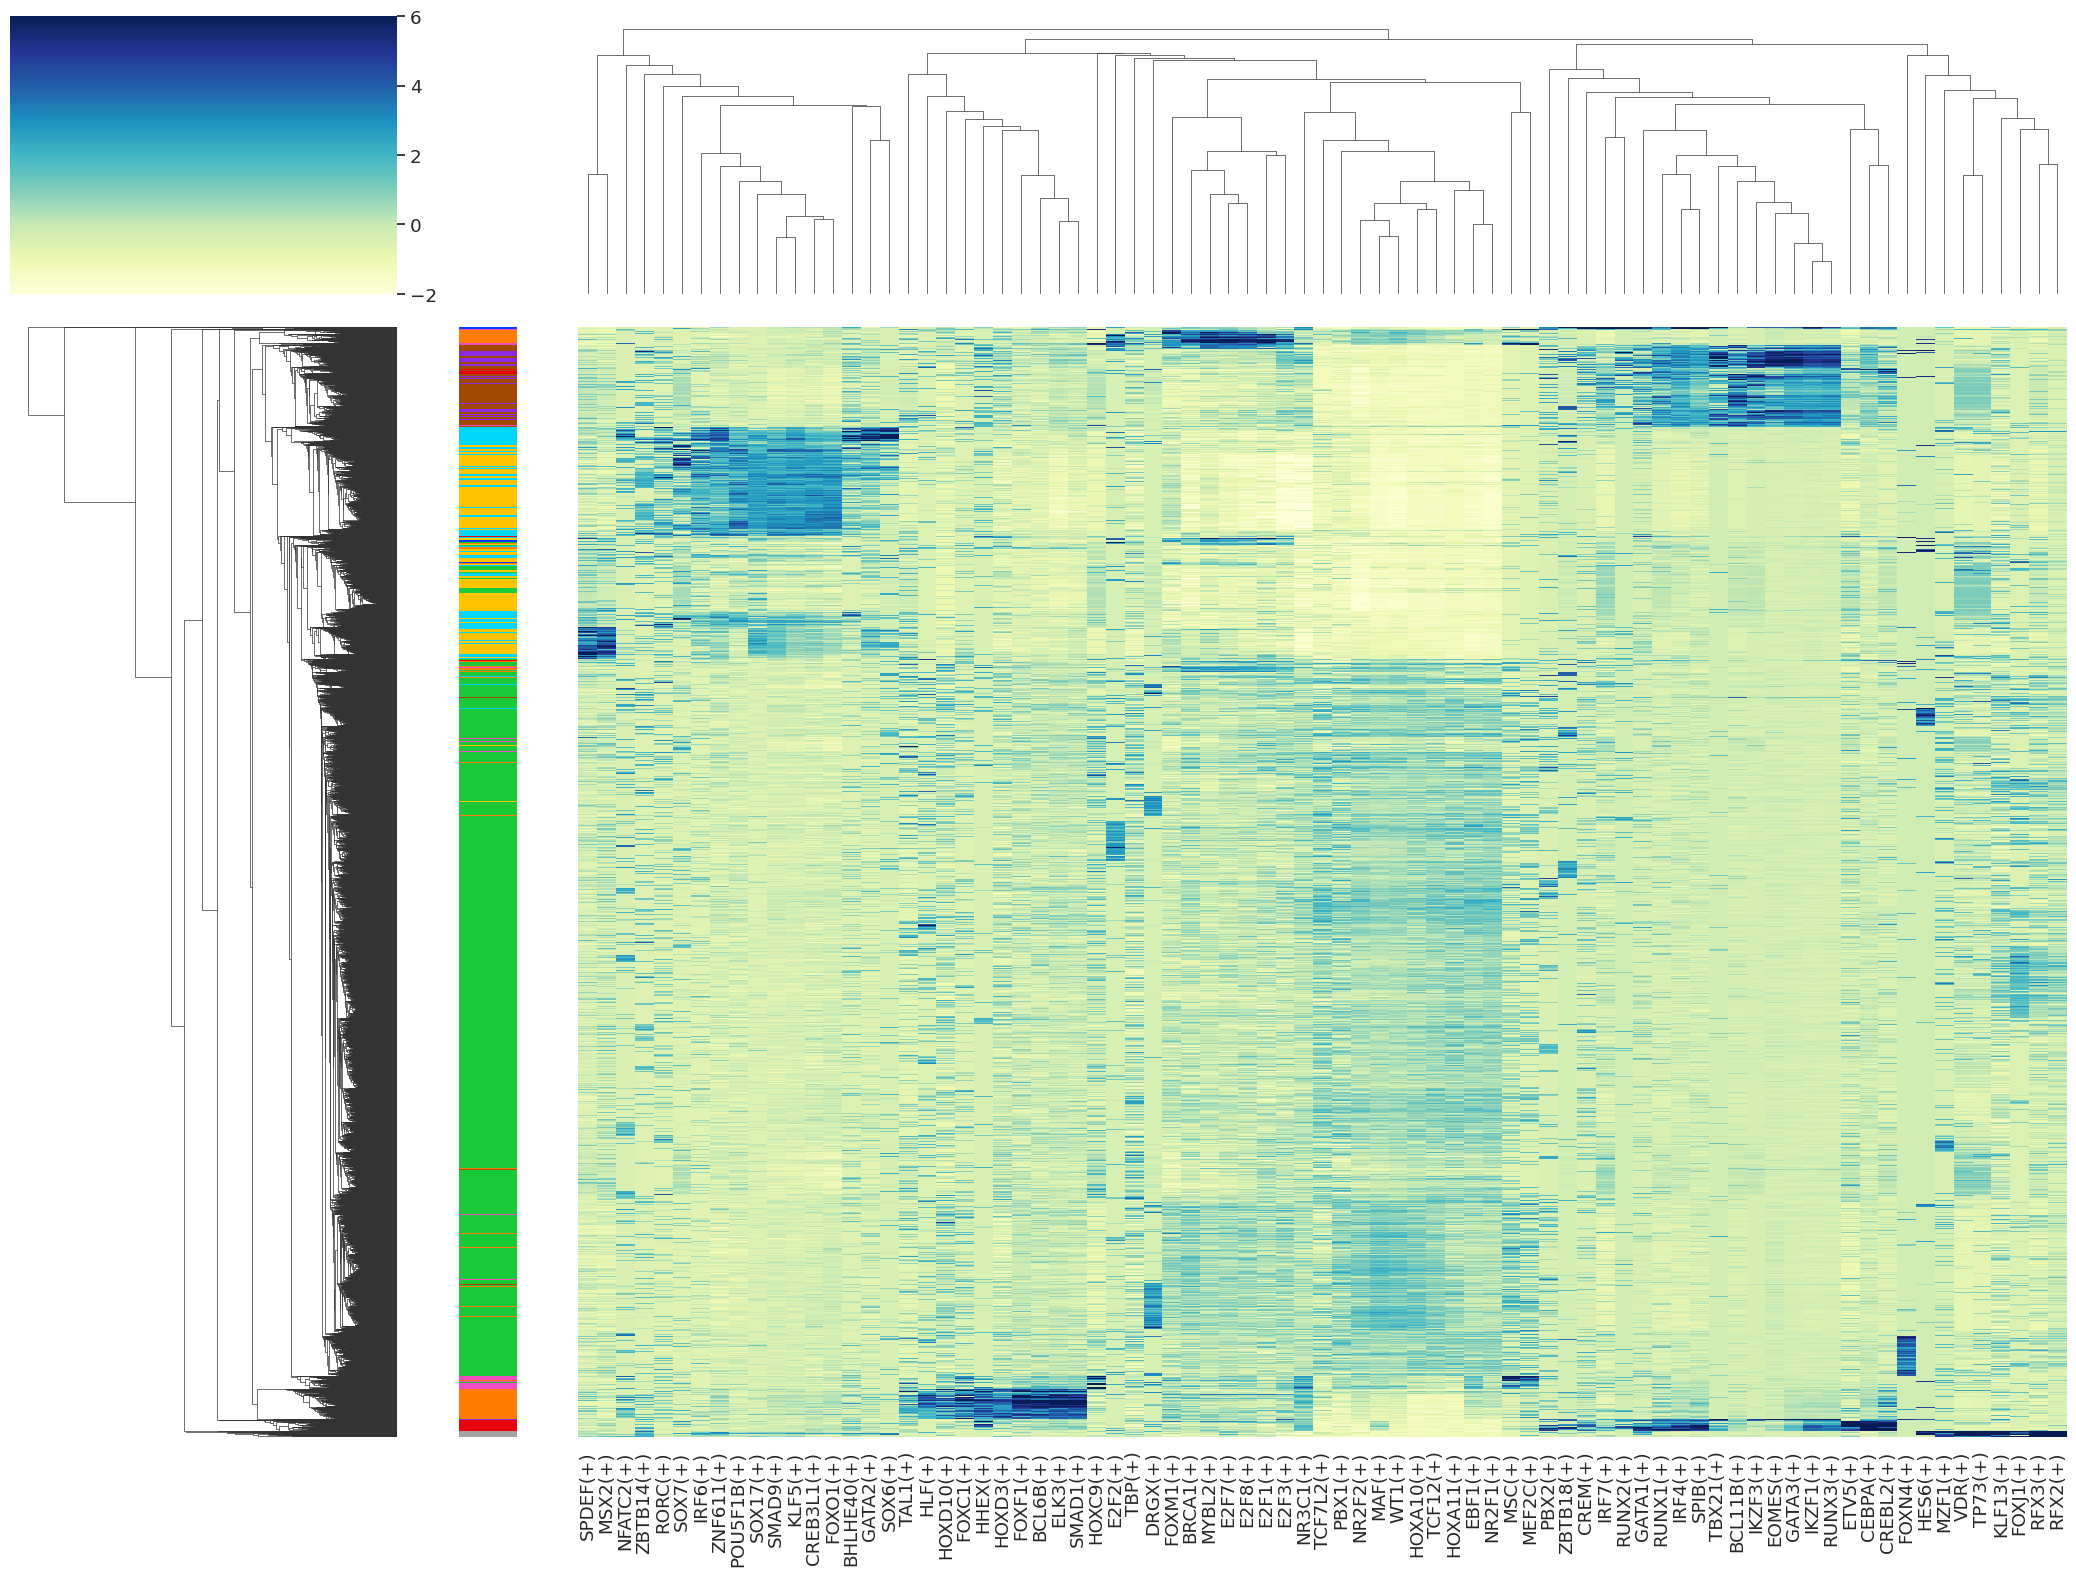

In [98]:
topreg_genes = []
for i,c in enumerate(cats_genes):
    topreg_genes.extend(
        list(rss_genes.T[c].sort_values(ascending=False)[:10].index)
    )
topreg_genes = list(set(topreg_genes))

colors = sns.color_palette('bright',n_colors=len(cats_genes) )
colorsd = dict( zip( cats_genes, colors ))
colormap = [ colorsd[x] for x in cellAnnot_genes['cell_type'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats_genes, size=1.0)
plt.savefig("genes-cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg_genes], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("genes-cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")


In [109]:
cellAnnot_genes['cell_type']

CellID
Pro1_Pro1_GCAACGCTGGGACCCT      pFib
Pro1_Pro1_CCCGTAGGAGAGTGAC      gEpi
Pro1_Pro1_CCCTACTGAGTCGTTA      gEpi
Pro1_Pro1_GTTAGACACCCCGATG      Fib0
Pro1_Pro1_CCCATGACTGGATGCA      Fib0
                                ... 
R2F16_R2F16_AGGTGACGACAGTACT    Fib0
R2F16_R2F16_AGGTGTGGATTCACCC    lEpi
R2F16_R2F16_AGGTGTTACCATGGAG    Fib0
R2F16_R2F16_AGGTGCAGACTCAATG    lEpi
R2F16_R2F16_AGGTGGCCTCCCAAGC    Fib0
Name: cell_type, Length: 18769, dtype: category
Categories (12, object): ['DC', 'Endo', 'Fib0', 'Mac', ..., 'gEpi', 'lEpi', 'pEpi', 'pFib']

['NR2F1(+)', 'NR2F2(+)', 'HOXA11(+)', 'TCF7L2(+)', 'MSC(+)', 'TCF12(+)', 'HOXA13(+)', 'MAF(+)', 'MEIS1(+)', 'WT1(+)', 'HOXA10(+)', 'EBF1(+)', 'PBX1(+)']


/opt/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


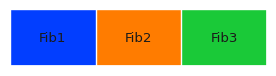

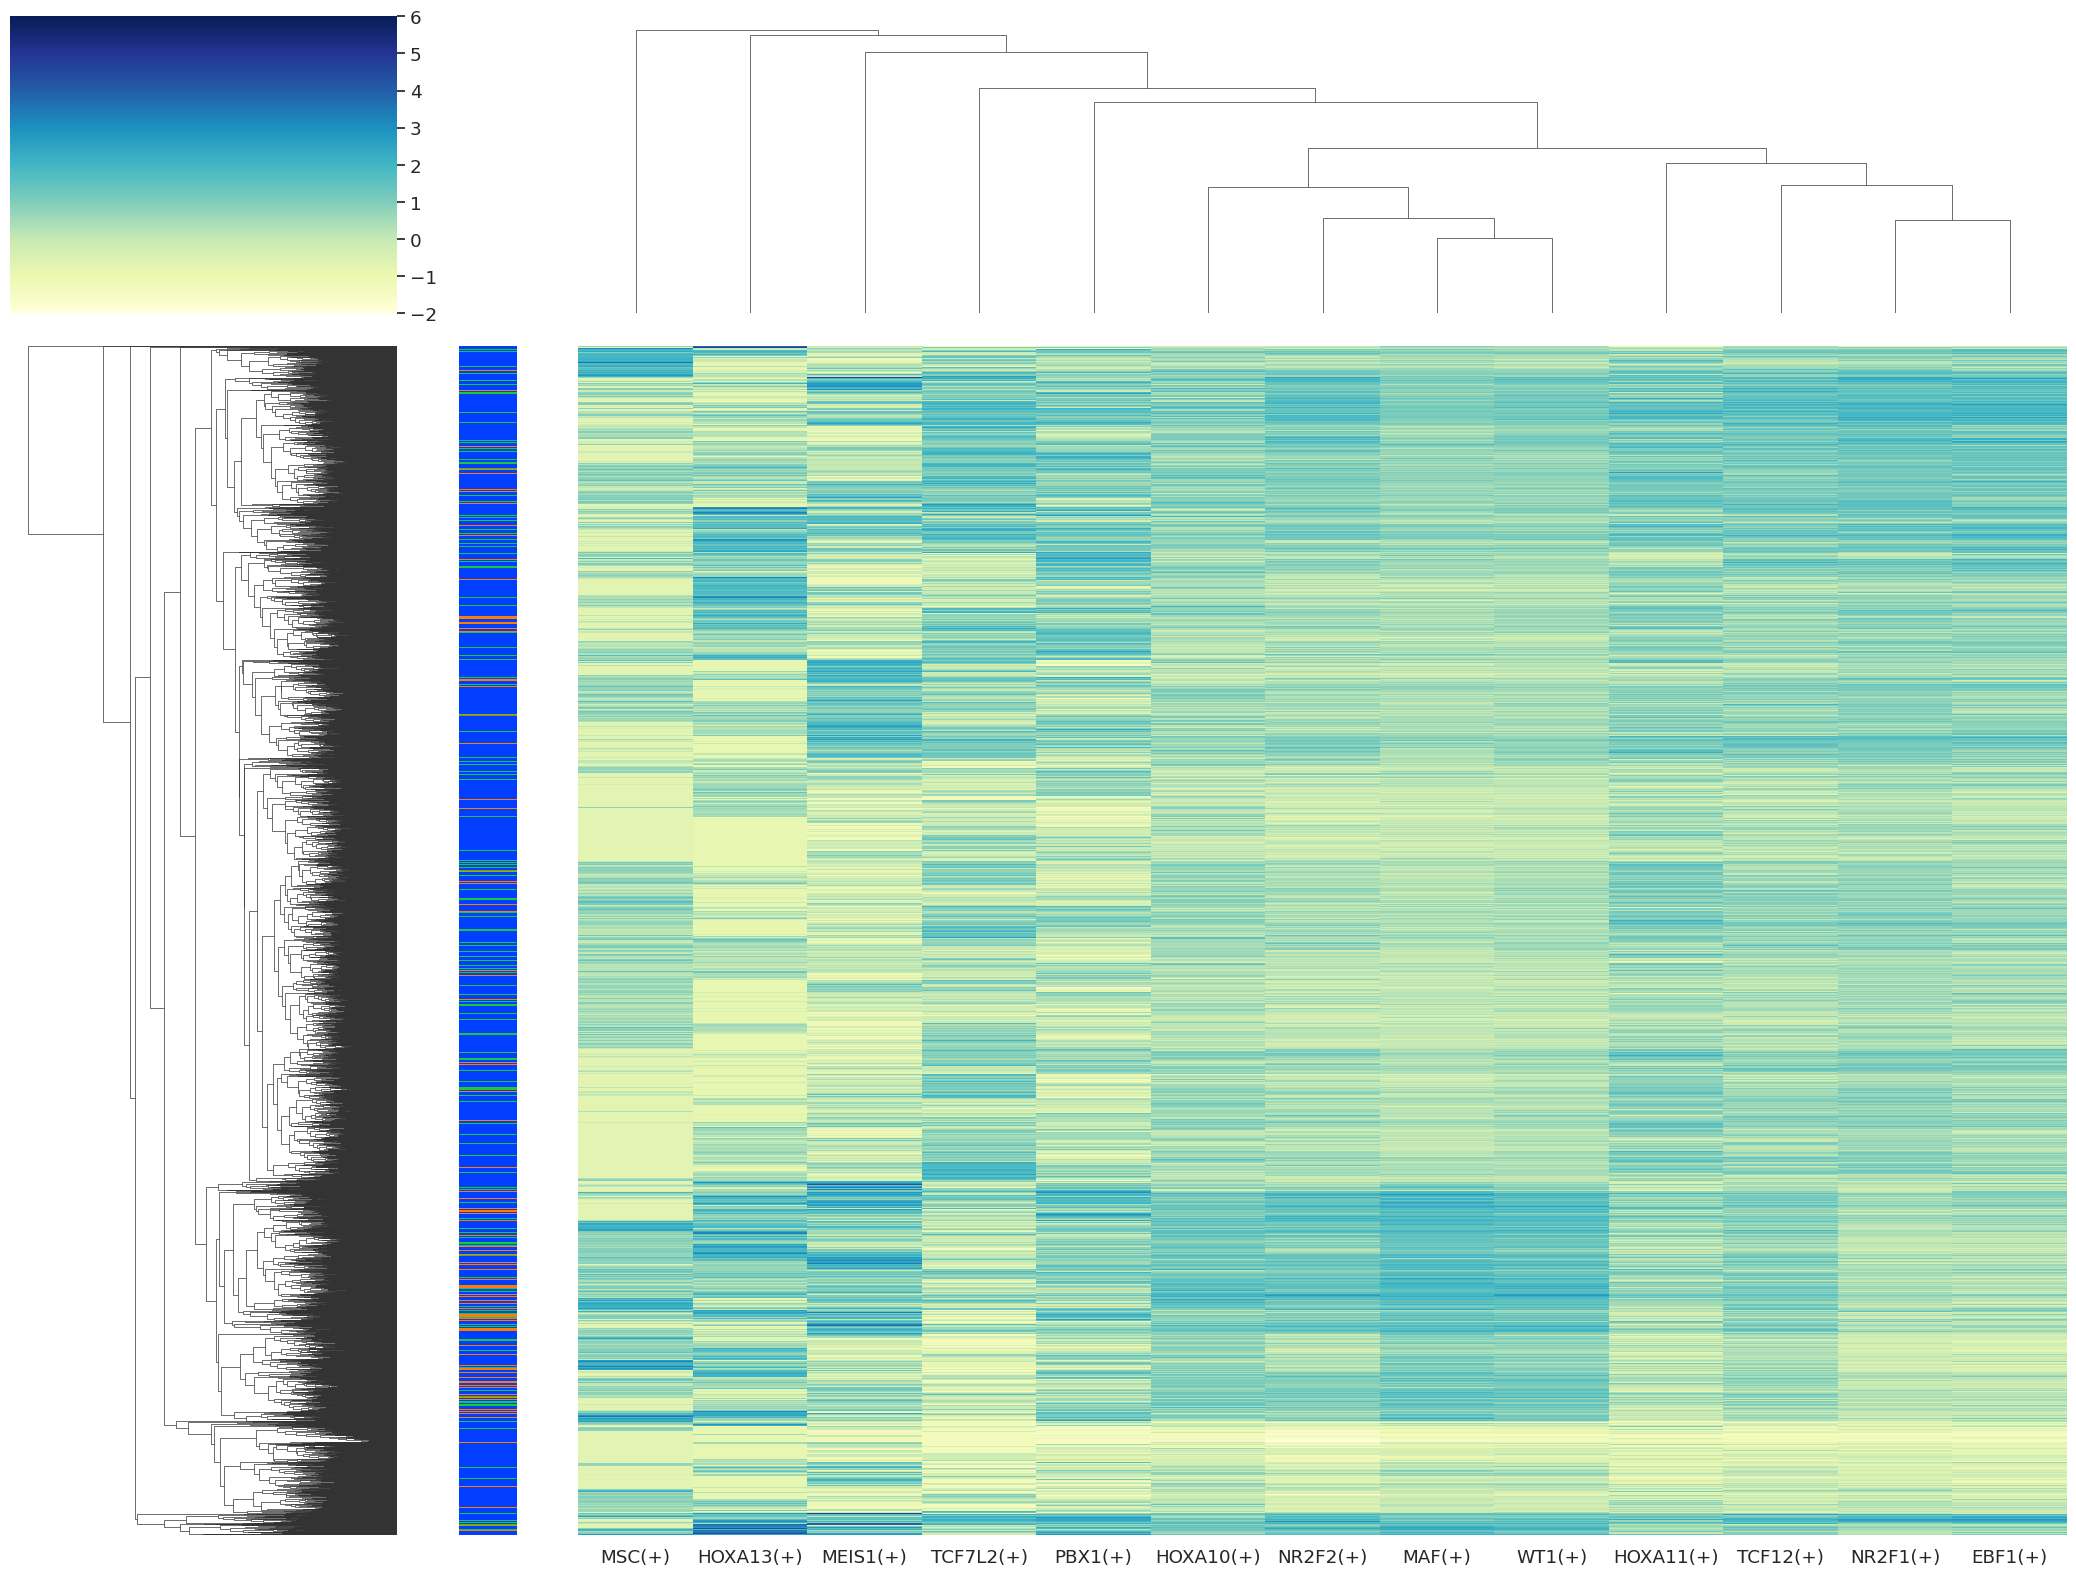

In [112]:
cells = cellAnnot_trans[cellAnnot_trans['cell_type'].str.contains("Fib") ].index.values
cats_trans = ['Fib1', 'Fib2', 'Fib3']
topreg_trans = []
for i,c in enumerate(cats_trans):
    topreg_trans.extend(
        list(rss_trans.loc[cats_trans,].T[c].sort_values(ascending=False)[:10].index)
    )
topreg_trans = list(set(topreg_trans))
print(topreg_trans)

colors = sns.color_palette('bright',n_colors=len(cats_trans) )
colorsd = dict( zip( cats_trans, colors ))
colormap = [ colorsd[x] for x in cellAnnot_trans.loc[cells, 'cell_type'] ]


sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats_trans, size=1.0)
plt.savefig("trans-cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z.loc[cells,topreg_trans], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("trans-cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

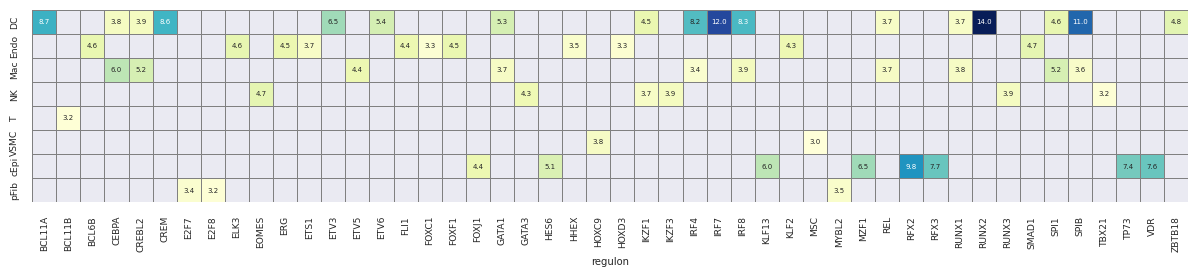

In [141]:
# genes
signature_column_names = list(auc_mtx.columns)
df_scores = auc_mtx[signature_column_names].copy()
df_scores['cell_type'] = auc_mtx.index.map(cellAnnot_genes.cell_type.to_dict())
df_results = ((df_scores.groupby(by='cell_type').mean() - auc_mtx[signature_column_names].mean())/ auc_mtx[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[0:-3], df_results.regulon))
df_results[(df_results.Z >= 1.5)].sort_values('Z', ascending=False).head()

df_heatmap = pd.pivot_table(data=df_results[(abs(df_results.Z) >= 3)].sort_values('Z', ascending=False),
                           index='cell_type', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale=0.6)
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 5})
ax1.set_ylabel('')
savesvg(f"{indir}/genes-celltype-z.svg", fig)

In [183]:
sig_reg = df_results[(abs(df_results.Z) >= 0.5)].sort_values('Z', ascending=False)['regulon'].values
df_results[df_results['regulon'].isin(sig_reg)]

,cell_type,regulon,Z
5,Fib1,BCLAF1,0.103353
7,Fib1,BRCA1,0.131530
11,Fib1,CEBPD,0.229665
13,Fib1,CHD1,0.312160
27,Fib1,EBF1,0.543910
...,...,...,...
521,Fib3,TCF12,0.727599
523,Fib3,TEAD1,0.521047
532,Fib3,WT1,0.686326
538,Fib3,ZBTB20,0.594332


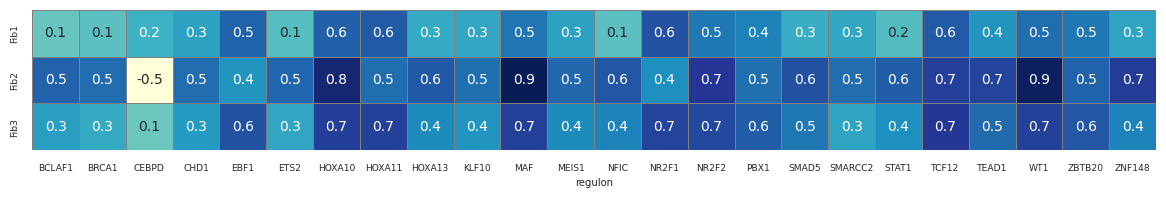

In [185]:
signature_column_names = list(auc_mtx.columns)
df_scores = auc_mtx.loc[cells, signature_column_names].copy()
df_scores['cell_type'] = auc_mtx.loc[cells,].index.map(cellAnnot_trans.loc[cells,].cell_type.to_dict())
df_results = ((df_scores.groupby(by='cell_type').mean() - auc_mtx[signature_column_names].mean())/ auc_mtx[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[0:-3], df_results.regulon))
df_results[(abs(df_results.Z) >= 0.5)].sort_values('Z', ascending=False).head()

sig_reg = df_results[(abs(df_results.Z) >= 0.5)].sort_values('Z', ascending=False)['regulon'].values
df_results2 = df_results[df_results['regulon'].isin(sig_reg)]
df_heatmap = pd.pivot_table(data=df_results2.sort_values('Z', ascending=False),
                           index='cell_type', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale=1.5)
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 10})
ax1.set_ylabel('')
savesvg(f"{indir}/trans-celltype-z.svg", fig)

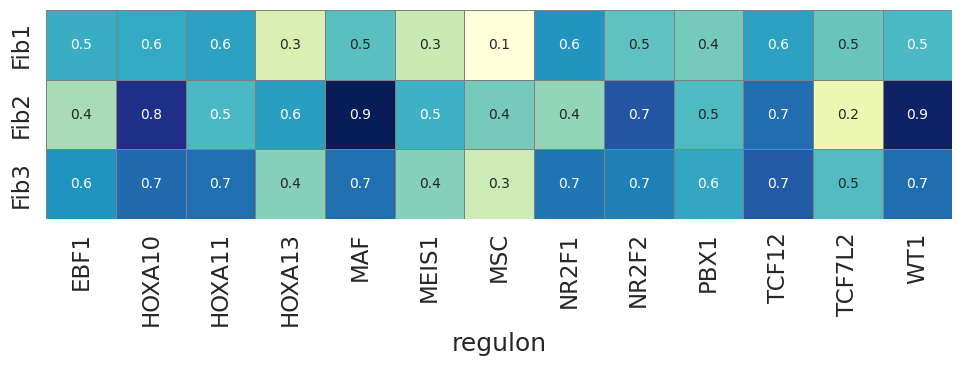

In [163]:
signature_column_names = topreg_trans
df_scores = auc_mtx.loc[cells, signature_column_names].copy()
df_scores['cell_type'] = auc_mtx.loc[cells,].index.map(cellAnnot_trans.loc[cells,].cell_type.to_dict())
df_results = ((df_scores.groupby(by='cell_type').mean() - auc_mtx[signature_column_names].mean())/ auc_mtx[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[0:-3], df_results.regulon))
df_results[(df_results.Z >= 1.5)].sort_values('Z', ascending=False).head()

df_heatmap = pd.pivot_table(data=df_results.sort_values('Z', ascending=False),
                           index='cell_type', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
sns.set(font_scale=1.5)
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 10})
ax1.set_ylabel('')
savesvg(f"{indir}/trans-celltype-z.svg", fig)



In [75]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = cellAnnot_genes
names = list(map(op.attrgetter('name'), filter(lambda r: r.score > 8.0, regulons)))
sc.pl.stacked_violin(aucell_adata, names, groupby='cell_type',
          save=' - GSE115978 - regulons.svg')

/tmp/msu/ipykernel_115241/3788988420.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  aucell_adata = sc.AnnData(X=auc_mtx.sort_index())


NameError: name 'regulons' is not defined

['MYBL2', 'E2F7', 'E2F8', 'FOXM1', 'BRCA1', 'TCF12', 'NR2F1', 'HOXA10', 'HOXA11', 'WT1']


/tmp/msu/ipykernel_69157/3077384535.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] + '(+)'], ax=ax, norm_hist=True, bins=100)
/tmp/msu/ipykernel_69157/3077384535.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] + '(+)'], ax=ax, norm_hist=True, bins=100)
/tmp/m

IndexError: list index out of range

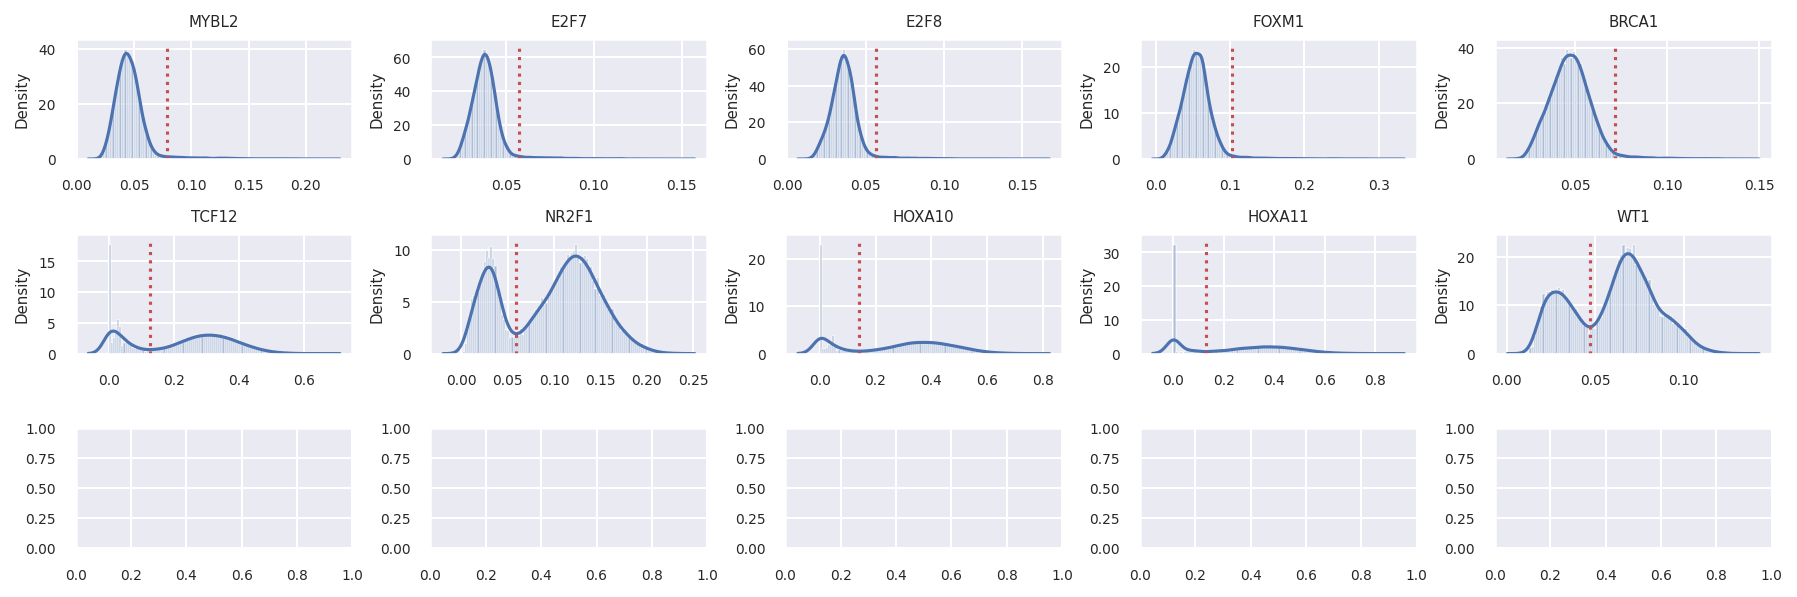

In [134]:
# select regulons:
r = df_results.loc[df_results['cell_type'].str.contains('Fib', na = False)].sort_values('Z', ascending=False).groupby(by='cell_type').head(5)['regulon'].to_list()
print(r)
fig, axs = plt.subplots(3, 5, figsize=(12, 4), dpi=150, sharey=False)
for i, ax in enumerate(axs.flatten()):
    sns.distplot(auc_mtx[ r[i] + '(+)'], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] + '(+)' ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('fib-top3-regulon-thresolds.pdf', dpi=600, bbox_inches='tight')

['NR2F1(+)', 'NR2F2(+)', 'HOXA11(+)', 'TCF7L2(+)', 'MSC(+)', 'TCF12(+)', 'HOXA13(+)', 'MAF(+)', 'MEIS1(+)', 'WT1(+)', 'HOXA10(+)', 'EBF1(+)', 'PBX1(+)']


/tmp/msu/ipykernel_69157/3681895076.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i]], ax=ax, norm_hist=True, bins=100)
/tmp/msu/ipykernel_69157/3681895076.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i]], ax=ax, norm_hist=True, bins=100)
/tmp/msu/ipykernel_691

IndexError: list index out of range

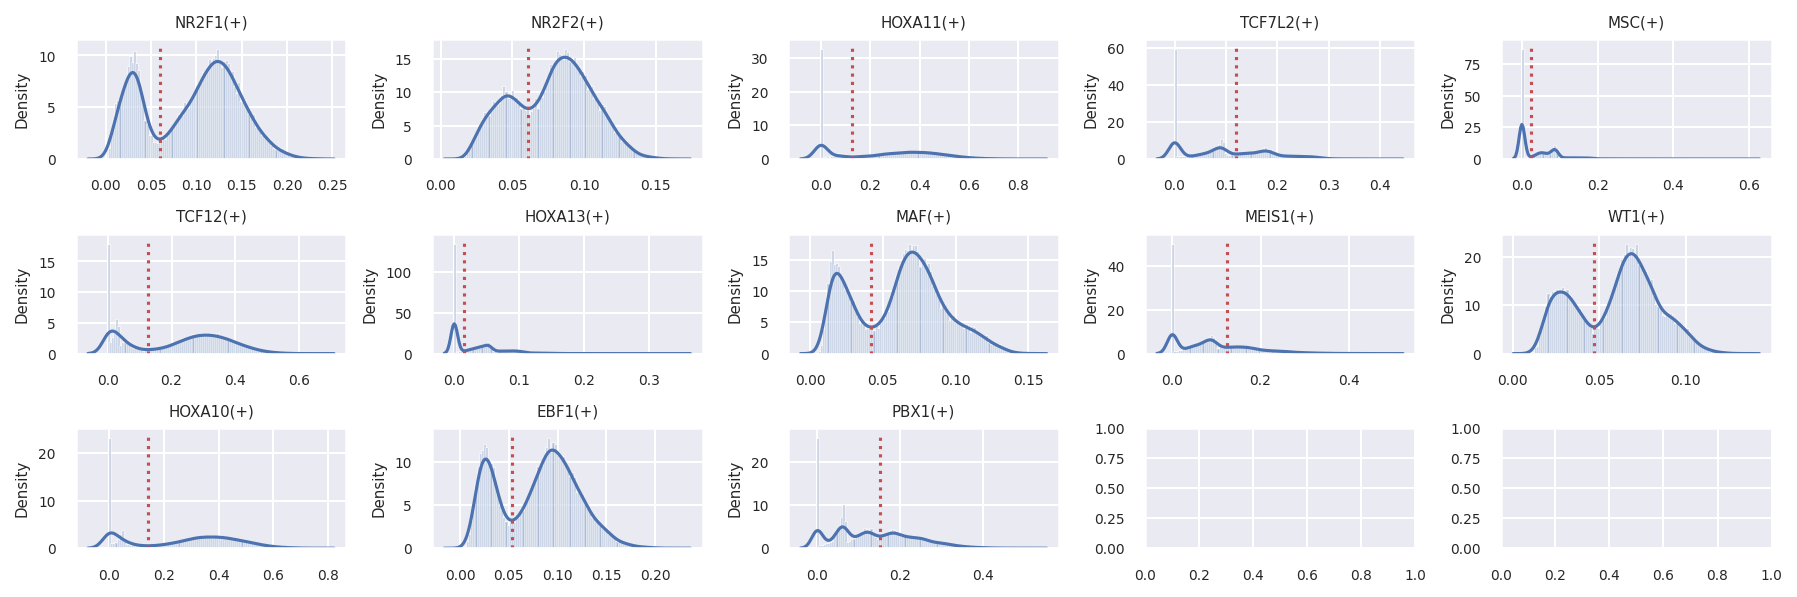

In [138]:
# select regulons:
r = topreg_trans
print(r)
fig, axs = plt.subplots(3, 5, figsize=(12, 4), dpi=150, sharey=False)
for i, ax in enumerate(axs.flatten()):
    sns.distplot(auc_mtx[ r[i]], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('fib-top-regulon-thresolds.pdf', dpi=600, bbox_inches='tight')

In [136]:
len(topreg_trans)

13